# Project 2
Authors: Richie Rivera and Naomi Buell

*Instructions*
1. *Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.*
2. *Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.*
3. *What can you infer about each of the distinct groups?*

## 1. Identify and load data

First, we load the necessary libraries.

In [1]:
# Import libraries
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
import io
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import math

We identified a bipartite One Piece character network dataset used by Sugashita and Masuda (2023).[^1] The data is available on GitHub here: https://github.com/KS-92/Manga. The unprojected data are equivalent to a temporal bipartite graph in which the two types of nodes are characters and pages, and an edge connects a character and a page in which the character appears. Note that the characters are anonymized and because we are interested in interaction between the characters, the isolated nodes in the character networks are excluded from the analysis.

[^1]: [Sugishita, K., Masuda, N. Social network analysis of manga: similarities to real-world social networks and trends over decades. Appl Netw Sci 8, 79 (2023). https://doi.org/10.1007/s41109-023-00604-0](#references)

In [2]:
from networkx.algorithms import bipartite

# Download the zip file
zip_url = 'https://github.com/KS-92/Manga/raw/main/Manga_network_data.zip'
response = requests.get(zip_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Extract the required files to memory
    with z.open('Manga_network_data/Temporal/Temporal_One_Piece.csv') as f:
        temporal_one_piece = pd.read_csv(f)
    with z.open('Manga_network_data/Static/Static_One_Piece.edgelist') as f:
        static_one_piece = nx.read_weighted_edgelist(f, nodetype=int)
        static_one_piece_df = nx.to_pandas_edgelist(static_one_piece)
        
# Create the bipartite graph: nodes are characters and pages, edges connect characters to pages they appear on
B = nx.Graph()
characters = set(temporal_one_piece['i']).union(set(temporal_one_piece['j']))
pages = set(temporal_one_piece['t'])

for _, row in temporal_one_piece.iterrows():
    B.add_edge(row['i'], row['t'])

# Get the character and page node lists (as in the bipartite sets)
character_list = sorted(characters)
page_list = sorted(pages)

print("Biadjacency matrix")
print(bi.biadjacency_matrix(B, character_list, page_list))

Biadjacency matrix
<Compressed Sparse Row sparse array of dtype 'int64'
	with 1039 stored elements and shape (34, 475)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 10)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 22)	1
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  (0, 26)	1
  (0, 27)	1
  :	:
  (30, 437)	1
  (30, 438)	1
  (30, 439)	1
  (30, 441)	1
  (30, 442)	1
  (30, 443)	1
  (30, 444)	1
  (30, 445)	1
  (30, 446)	1
  (30, 447)	1
  (30, 448)	1
  (30, 474)	1
  (31, 458)	1
  (31, 459)	1
  (31, 460)	1
  (31, 461)	1
  (31, 462)	1
  (31, 463)	1
  (31, 464)	1
  (31, 465)	1
  (31, 466)	1
  (31, 468)	1
  (31, 469)	1
  (31, 470)	1
  (31, 471)	1


The biadjacency matrix shows there are 34 characters (represented as rows) and 475 unique pages (represented as columns) in the dataset. There are 1,039 edges between characters and pages. Coord (0,0) with a value of 1 (binary indicator that the character appeared on that page) respresents character 0 appearing on page 0, for e.g.

The authors projected this bipartite data into a network of character nodes. In the character network, two characters are connected by an edge if and only if they appear on the same page at least once. The authors provide this helpful visualization of the projection:

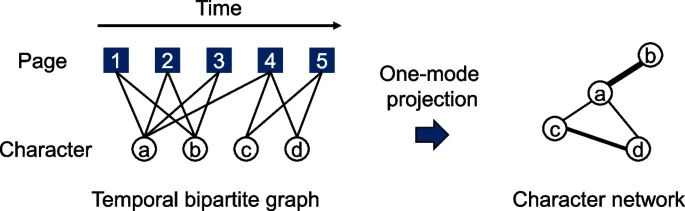

We read in two projected datasets:

1. A time-stamped copresence of characters in One Piece volumes one through three, which we read in as `temporal_once_piece` below. The copresence of characters on each page were recorded as interaction between the characters, where `i` is the source character, `j` is the target character, and `t` is the time stamp (page number).

In [3]:
# Show the first few rows of each dataframe
print(temporal_one_piece.head())
# Show summary statistics of the temporal dataset
print(temporal_one_piece.describe())

   i  j  t
0  1  2  3
1  1  2  4
2  1  2  5
3  1  2  6
4  1  2  7
                 i            j            t
count  2035.000000  2035.000000  2035.000000
mean      9.760688    19.908600   299.924816
std       9.704748     8.142626   158.702757
min       1.000000     2.000000     3.000000
25%       1.000000    12.000000   154.000000
50%      10.000000    20.000000   312.000000
75%      19.000000    27.000000   464.500000
max      32.000000    34.000000   523.000000


The pages with character interactions go from page 3 to page 523. There are 2,035 edges in `temporal_one_piece`, meaning there were 2,035 times that 2 characters interacted on a page.

2. A static character network, which we read in as `static_one_piece`. The static character network is an aggregate of the temporal character network over time, where the `weight` of an edge is the number of pages on which the two characters (`source` and `target` characters) are copresent.

In [4]:
print(static_one_piece_df.head())
print(static_one_piece_df.describe())

   source  target  weight
0       1       2    31.0
1       1       4    16.0
2       1      26    19.0
3       1      33     9.0
4       1      30    13.0
           source      target      weight
count  130.000000  130.000000  130.000000
mean    15.269231   18.292308   15.653846
std     11.751819    8.680769   23.330026
min      1.000000    2.000000    1.000000
25%      2.000000   11.000000    6.000000
50%     14.000000   20.000000   10.000000
75%     26.750000   25.000000   16.750000
max     34.000000   34.000000  177.000000


There are 130 combinations of character pairs that appear together on at least one page. E.g., character 1 and character 2 appear together on 31 pages, character 1 and character 4 appear together on 16 pages, etc.

## 2. Perform island method

First, we visualize the full graph:

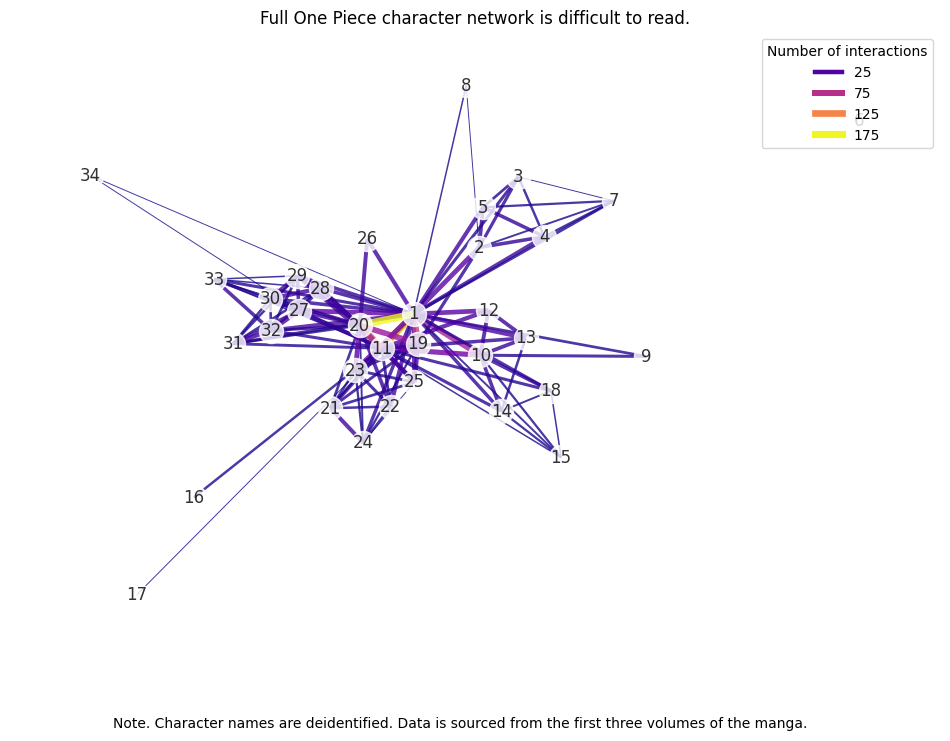

In [5]:
# Calculate weights and log weights for edges
weights = [static_one_piece[u][v]['weight'] for u, v in static_one_piece.edges()]
log_weights = [math.log(data['weight']) for u, v, data in static_one_piece.edges(data=True)]

# Assign colors
cmap = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Draw the graph
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx(
    static_one_piece,
    ax=ax,
    width=log_weights,  # Scale down the widths for better visibility
    edge_color=weights,
    edge_cmap=cmap,
    node_color='white',
    with_labels=True,
    alpha=0.8
)

# Remove border around the graph
for spine in ax.spines.values():
    spine.set_visible(False)

# Add titles and note
# Set a two-line title with different font sizes using two separate text objects
ax.set_title('Full One Piece character network is difficult to read.')
fig.text(0.5, 0.01, 'Note. Character names are deidentified. Data is sourced from the first three volumes of the manga.', ha='center', fontsize=10)

# Add a legend for edge width
legend_weights = [25, 75, 125, 175]
legend_log_weights = [math.log(w) for w in legend_weights]
legend_colors = [cmap(norm(w)) for w in legend_weights]
legend_lines = [
    Line2D([0], [0], color=color, linewidth=lw, label=f'{w}')
    for w, lw, color in zip(legend_weights, legend_log_weights, legend_colors)
]
ax.legend(
    handles=legend_lines,
    title='Number of interactions',
    loc='upper right',
    fontsize=10,
    title_fontsize=10,
    frameon=True
)

plt.show()

To get a beter sense of the network structure, we apply the island method to reduce the size of the network. We choose a threshold of 25 pages of interactions, which reduces the number of edges from 130 to 19. The resulting graph is below:

In [6]:
# The function below takes a graph, and applies a threshold (“water level”), letting all edges above a certain value through, and removing all others.
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, **edata)
    return g2

# This function will return a list of graph objects, each corresponding to a specific water level.
def island_method(g, iterations=10):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

# Now let’s isolate the biggest component of the One Piece character network, and separate it into subparts using the island method:
largest_cc_nodes = max(nx.connected_components(static_one_piece), key=len)
cc = static_one_piece.subgraph(largest_cc_nodes).copy()
islands = island_method(cc)
print("Threshold level, Size of the graph, Number of connected components")
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    num_components = nx.number_connected_components(i[1])
    print(i[0], len(i[1]), num_components)
    

Threshold level, Size of the graph, Number of connected components
1 33 1
18 17 2
35 5 1
52 5 1
69 4 1
86 3 1
103 3 1
120 3 1
137 3 1
154 2 1
171 2 1


When all links with a value of 1 (i.e., one joint-appearance and never appearing together again) are dropped, the network contains 1 island subgraph representing a group of 33 unique characters appearing with one another. Since one-off appearances could be considered coincidental, this is a very useful result. Repeated joint-appearances are more likely to happen between characters that interact repeatedly and thus have developed some kind of relationship.

When links with a value of 18 or fewer are dropped, 17 characters remain in the network, and the network separates into 2 island subgraphs representing 2 separate groups of characters appearing with one another. 

Raising the threshold to 35 dramatically reduces the size of the graph to just 5 characters, and raising the threshold further does not eliminate many more nodes. 

We choose to visualize the island method with a threshold of 18 joint-appearances to illustrate the two separated cliques in the One Piece network.

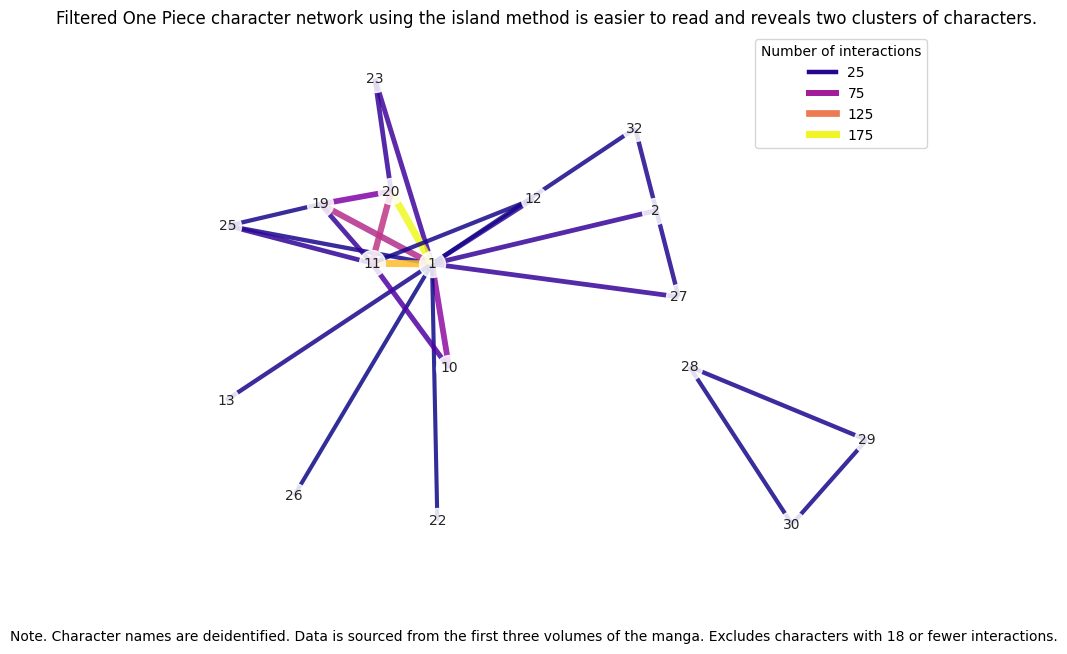

In [7]:
# Filter to the island with threshold 1
static_one_piece_filtered = islands[1][1]

# Calculate weights and log weights for edges
weights = [static_one_piece_filtered[u][v]['weight'] for u, v in static_one_piece_filtered.edges()]
log_weights = [math.log(data['weight']) for u, v, data in static_one_piece_filtered.edges(data=True)]

# Assign colors
cmap = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Draw the graph with a spring layout and increased repulsion (lower k) to bring islands closer
fig, ax = plt.subplots(figsize=(10, 7))
# Increase the number of iterations and lower k to reduce distance between components
pos = nx.spring_layout(static_one_piece_filtered, k=9, iterations=200, seed=42)
nx.draw_networkx(
    static_one_piece_filtered,
    pos=pos,
    ax=ax,
    width=log_weights,
    edge_color=weights,
    edge_cmap=cmap,
    node_color='white',
    with_labels=True,
    node_size=350,
    font_size=10,
    alpha=0.85
)

# Remove border around the graph
for spine in ax.spines.values():
    spine.set_visible(False)

# Add titles and note
# Set a two-line title with different font sizes using two separate text objects
ax.set_title('Filtered One Piece character network using the island method is easier to read and reveals two clusters of characters.')
fig.text(0.5, 0.01, 'Note. Character names are deidentified. Data is sourced from the first three volumes of the manga. Excludes characters with 18 or fewer interactions.', ha='center', fontsize=10)

# Add a legend for edge width
legend_weights = [25, 75, 125, 175]
legend_log_weights = [math.log(w) for w in legend_weights]
legend_colors = [cmap(norm(w)) for w in legend_weights]
legend_lines = [
    Line2D([0], [0], color=color, linewidth=lw, label=f'{w}')
    for w, lw, color in zip(legend_weights, legend_log_weights, legend_colors)
]
ax.legend(
    handles=legend_lines,
    title='Number of interactions',
    loc='upper right',
    fontsize=10,
    title_fontsize=10,
    frameon=True
)

plt.show()

## 3. Inference

We can infer that... Zeus has some of the best boons imo, I love him.

With the graph above, we come up with a bit of an unexpected result. Given that this story closely follows Luffy, we can assume that id 1 is Luffy himeself as there are many strong edges between himself and a very closely connected group of nodes. A few of these edges have over 100 interactions as the next few in this filtered subgraph show that 25 is fairly high. 

In addition to the fact that Character 1 is very central, we can also see that there are a few cliques. Specifically, (1, 11, 19, 20) are all connected to each other with strong edges. This indicates that these characters interact with each other often and are likely to be part of many of the same storylines. As so are (1, 11, 19, 25), (1, 11, 12), and (1, 20, 23). These groups of 3+ characters are likely to be part of the same story arcs and have strong relationships with each other. Alteratively, some of these characters may have been introduced much earlier on than others, giving them more opportunities to interact with each other.

These collection of nodes and edges is similar to that of a hub and spoke network where a central node (a hub) will connect to many much smaller and less connected nodes (spokes). This is to be expected in a story that follows a main character with subplots developed around slightly less important characters and their intersection with said main character.

The one major exception to all the above is the triad formed between (28, 29, 30). These three characters are very strongly connected to each other but have no connection to the rest of the network. This indicates that these characters are likely part of a subplot that does not intersect with the main storyline... yet. As it's stated from the readme of the github repository, these characters are anonymized, so we cannot be sure of their identities. However, given the strength of their connections to each other, we can assume that they are important characters in the story and that a thorough readthrough of the first three volumes of One Piece would likely reveal their identities.